## <font color='darkblue'>Thực hành Huấn luyện mạng trí tuệ nhân tạo:

Trong bài này, chúng ta sẽ thực hành: 
- (i) tiền xử lý dữ liệu
- (ii) huấn luyện Neural Net

Bộ dữ liệu được sử dụng là bộ [Kaggle Titanic](https://www.kaggle.com/c/titanic); trong đó, đầu vào là thông tin của hành khách trên tàu Titanic (bạn xem chi tiết trong file `description.txt` đính kèm), đầu ra là một trong hai lớp sống/chết (1 | 0). Mình có đính kèm các file dữ liệu: `train.csv` - tập huấn luyện, `val.csv` - tập validation, `test.csv` - tập kiểm tra (chỉ có đầu vào); thật ra, Kaggle chỉ cung cấp hai file là `train.csv` và `test.csv`, mình đã tách file `train.csv` của Kaggle ra hai file là `train.csv` (80%) và `val.csv` (20%).

### <font color='blue'>Import</font>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
#import cPickle
# You can also import other things ...

### <font color='blue'>Đọc dữ liệu tập huấn luyện và tập validation vào data frame

In [2]:
train_df = pd.read_csv('./sample_datas/titanic/train.csv', index_col=0)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Name      712 non-null    object 
 3   Sex       712 non-null    object 
 4   Age       574 non-null    float64
 5   SibSp     712 non-null    int64  
 6   Parch     712 non-null    int64  
 7   Ticket    712 non-null    object 
 8   Fare      712 non-null    float64
 9   Cabin     160 non-null    object 
 10  Embarked  711 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


In [3]:
val_df = pd.read_csv('./sample_datas/titanic/val.csv', index_col=0)
val_df.info()
val_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 529 to 685
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  179 non-null    int64  
 1   Pclass    179 non-null    int64  
 2   Name      179 non-null    object 
 3   Sex       179 non-null    object 
 4   Age       140 non-null    float64
 5   SibSp     179 non-null    int64  
 6   Parch     179 non-null    int64  
 7   Ticket    179 non-null    object 
 8   Fare      179 non-null    float64
 9   Cabin     44 non-null     object 
 10  Embarked  178 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.9250,NaN,S
411,0,3,"Sdycoff, Mr. Todor",male,NaN,0,0,349222,7.8958,NaN,S
449,1,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C
792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9000,C65,C
261,0,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q
315,0,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S


### <font color='blue'>Tiền xử lý

#### **Tiền xử lý tập huấn luyện**

In [4]:
train_input_df = train_df.iloc[:, 1:]
train_output_df = train_df.Survived

##### Xây dựng `train_X` từ `train_input_df`

(`train_X` là mảng numpy chứa các véc-tơ đầu vào mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

Đầu tiên, ta sẽ tiến hành: 
- Bỏ cột `Cabin` vì cột này có nhiều giá thiếu (552/712).
- Bỏ cột `Ticket` vì cột này có giá trị không phải dạng số, sẽ cần phải tốn sức để chuyển sang dạng số , vì nó có quá nhiều định dạng và rất cần rất nhiều công sức và thời gian để có thể hiểu được các kí hiệu trên đó có nghĩa gì.

**Lưu ý** :

khi bỏ 2 cột `Cabin` và `Ticket` đi thì rất có thể sẽ làm mất thông tin để dự đoán `sống`|`chết`. Vì có khả năng đây là dữ liệu quan trọng liên quan đến vị trí nghỉ ngơi cụ thể trong từng khoang.


In [5]:
dropped_cols = ['Ticket', 'Cabin']
train_input_df.drop(dropped_cols, axis=1, inplace=True)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       574 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  711 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 50.1+ KB


Kế đến, ta sẽ xử lý các giá trị thiếu ở cột `Age` và cột `Embarked`. Ở đây, ta xử lý đơn giản là điền giá trị mean (giá trị trung bình) vào các giá trị thiếu ở cột `Age`, và điền giá trị mode (giá trị xuất hiện nhiều nhất) vào các giá trị thiếu ở cột `Embarked`. *Lưu ý là, khi điền các giá trị thiếu ở tập validation/test, ta sẽ sử dụng các giá trị mean/mode được tính từ tập huấn luyện*. Trong thực tế,  ta thường sẽ không biết ở thời điểm test biến đầu vào nào sẽ thiếu giá trị; do đó, ta có thể làm một cách tổng quát như sau: với biến đầu vào có giá trị số, ta sẽ điền giá trị mean; ngược lại, điền giá trị mode. Dưới đây, hàm `compute_mean_mode` sẽ tính từ tập huấn luyện giá trị mean/mode của *tất cả* các biến đầu vào; hàm `fill_missing_values` sẽ dùng các giá trị mean/mode này để điền giá trị thiếu cho một tập dữ liệu nào đó (tập huấn luyện/validation/kiểm tra).

In [6]:
names = train_input_df["Name"].to_list()
len(names)

712

In [7]:
apellation = set([name.split(',')[1].split('.')[0] for name in names])
apellation = list(apellation)
apellation

[' Mr',
 ' Miss',
 ' Master',
 ' Dr',
 ' the Countess',
 ' Capt',
 ' Jonkheer',
 ' Col',
 ' Don',
 ' Major',
 ' Mlle',
 ' Mme',
 ' Rev',
 ' Ms',
 ' Mrs',
 ' Lady']

In [8]:
def preprocessing_Name(input_df):
    index = input_df.index.values.tolist()
    vector = []
    for key in apellation:
        tmp = list([])
        for i in index:
            apell = input_df.loc[i]["Name"].split(',')[1].split('.')[0]
            if(apell == key):
                tmp.append(1.0)
            else:
                tmp.append(0.0)
        vector.append(tmp)
        k = 6
    for i in range(len(vector)):
        input_df.insert(k+i, apellation[i], vector[i], allow_duplicates = True)
    input_df.drop('Name', axis=1, inplace=True)
    return input_df

In [9]:
def compute_mean_mode(train_input_df):
    '''
    Computes means for numeric input variables and modes for non-numeric ones.
    
    Parameters
    ----------
    train_input_df : data frame
        The data frame containing training inputs.
    
    Returns
    -------
    mean_mode_dict : dictionary, len = # input variables (# columns) of train_input_df
        mean_mode_dict[<column_name>] = mean/mode of this column.
    '''
    dic = {}
    for column in train_input_df:
        num = 0
        for i in range(7000):
            try:
                a = train_input_df.loc[i][column]
                num = i
                break
            except:
                next
        if (isinstance(train_input_df.loc[num][column], str)):
            if(len(train_input_df[column].mode()) > 0):
                dic[column] = str(train_input_df[column].mode()[0])
            else:
                dic[column] = ''
        else:
            dic[column] = train_input_df[column].mean()
    return dic

In [10]:
mean_mode_dict = compute_mean_mode(train_input_df)
mean_mode_dict

{'Pclass': 2.3230337078651684,
 'Name': 'Abbott, Mr. Rossmore Edward',
 'Sex': 'male',
 'Age': 29.488815331010457,
 'SibSp': 0.5140449438202247,
 'Parch': 0.37359550561797755,
 'Fare': 32.18301095505618,
 'Embarked': 'S'}

In [11]:
def fill_missing_values(input_df, mean_mode_dict):
    '''
    Fills missing values for ALL columns of `input_df` using `mean_mode_dict`.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    mean_mode_dict : dictionary
        mean_mode_dict[<column_name>] = mean/mode of this column (estimated from the training set).
    
    Returns
    -------
    filled_input_df : data frame
        The data frame containing inputs after filling missing values.
    '''
    for column in input_df:
        df = input_df[pd.isnull(input_df).any(axis=1)]
        index = df.index.to_numpy()
        for i in index:
            if(pd.isnull(input_df.loc[i, column])):
                input_df.loc[i, column] = mean_mode_dict[column]
    return input_df

In [12]:
# Before filling
missing_age_mask = train_input_df.Age.isnull()
missing_embarked_mask = train_input_df.Embarked.isnull()
print(train_input_df.Age[missing_age_mask].head())
print()
print(train_input_df.Embarked[missing_embarked_mask].head())

PassengerId
496   NaN
649   NaN
32    NaN
299   NaN
368   NaN
Name: Age, dtype: float64

PassengerId
62    NaN
Name: Embarked, dtype: object


In [13]:
# Fill and check the result
train_input_df = fill_missing_values(train_input_df, mean_mode_dict)
print(train_input_df.Age[missing_age_mask].head())
print()
print(train_input_df.Embarked[missing_embarked_mask].head())
print()
train_input_df.info()

PassengerId
496    29.488815
649    29.488815
32     29.488815
299    29.488815
368    29.488815
Name: Age, dtype: float64

PassengerId
62    S
Name: Embarked, dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 66.2+ KB


Đến đây, ta đã bỏ các cột `Name`, `Ticket`, `Cabin`; và điền giá trị thiếu cho cột `Age`, `Embarked`. Kế đến, ta sẽ chuyển các cột có giá trị không phải dạng số (`Sex` và `Embarked`) sang dạng số. Vì `Sex` và `Embarked` là các biến có giá trị rời-rạc và không-có-thứ-tự nên ta có thể chuyển sang dạng "one-hot" (và bỏ cột cuối). Vd:

```
Sex    --> Female | Male
------     --------------
female --> 1      | 0
male   --> 0      | 1
female --> 1      | 0
```
và ta có thể bỏ cột `Male` đi.

In [14]:
def process_categorical_cols(input_df):
    '''
    Converts `Sex` column and `Embarked` column to one-hot forms.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    
    Returns
    -------
    numeric_input_df : data frame
        The data frame containing inputs after converting.
    '''
    sex_tag = ['female', 'male']
    Embarked_tag = ['C','Q','S']
    index = input_df.index.to_numpy()
    value_sex = []
    value_C = []
    value_Q = []
    
    print(len(input_df))
    
    try:
        for i in range(len(index)):
            if(input_df.loc[int(index[i])]['Sex'] == sex_tag[0]):
                value_sex.append(1.0)
            else:
                value_sex.append(0.0)
            if(input_df.loc[int(index[i])]['Embarked'] == Embarked_tag[0]):
                value_C.append(1.0)
            else:
                value_C.append(0.0)
            if(input_df.loc[int(index[i])]['Embarked'] == Embarked_tag[1]):
                value_Q.append(1.0)
            else:
                value_Q.append(0.0)
    
        input_df.insert(6, 'female', value_sex, allow_duplicates = True)
        input_df.insert(7, 'C', value_C, allow_duplicates = True)
        input_df.insert(8, 'Q', value_Q, allow_duplicates = True)
        input_df.drop('Sex', axis=1, inplace=True)
        input_df.drop('Embarked', axis=1, inplace=True)
    except:
        return input_df
    return input_df

In [15]:
train_input_df = process_categorical_cols(train_input_df)
train_input_df.info()

712
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  712 non-null    int64  
 1   Name    712 non-null    object 
 2   Age     712 non-null    float64
 3   SibSp   712 non-null    int64  
 4   Parch   712 non-null    int64  
 5   female  712 non-null    float64
 6   C       712 non-null    float64
 7   Q       712 non-null    float64
 8   Fare    712 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 71.8+ KB


In [16]:
train_input_df = preprocessing_Name(train_input_df)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Age            712 non-null    float64
 2   SibSp          712 non-null    int64  
 3   Parch          712 non-null    int64  
 4   female         712 non-null    float64
 5    Mr            712 non-null    float64
 6    Miss          712 non-null    float64
 7    Master        712 non-null    float64
 8    Dr            712 non-null    float64
 9    the Countess  712 non-null    float64
 10   Capt          712 non-null    float64
 11   Jonkheer      712 non-null    float64
 12   Col           712 non-null    float64
 13   Don           712 non-null    float64
 14   Major         712 non-null    float64
 15   Mlle          712 non-null    float64
 16   Mme           712 non-null    float64
 17   Rev           712 non-null    float64
 18   Ms     

Cuối cùng, ta sẽ xây dựng `train_X`. Để giúp Gradient Descent hội tụ nhanh hơn, ta sẽ chuẩn hóa để các cột của `train_X` có mean bằng 0 và có độ lệch chuẩn bằng 1. *Lưu ý là, khi chuẩn hóa `val_X`/`test_X`, ta sẽ dùng mean và độ lệch chuẩn được ước lượng từ tập huấn luyện.*

In [17]:
train_X = train_input_df.values
print(train_X.shape)

(712, 24)


In [18]:
# compute `X_mean` and `X_std`
X_mean = train_X.mean(axis=0)
X_std = train_X.std(axis=0)

In [19]:
print(X_mean)
print(X_std)

[2.32303371e+00 2.94888153e+01 5.14044944e-01 3.73595506e-01
 3.49719101e-01 5.80056180e-01 2.12078652e-01 4.63483146e-02
 7.02247191e-03 1.40449438e-03 1.40449438e-03 1.40449438e-03
 2.80898876e-03 1.40449438e-03 2.80898876e-03 2.80898876e-03
 1.40449438e-03 8.42696629e-03 1.40449438e-03 1.27808989e-01
 1.40449438e-03 1.79775281e-01 8.42696629e-02 3.21830110e+01]
[8.34392606e-01 1.31205457e+01 1.07438220e+00 8.00827868e-01
 4.76881171e-01 4.93549398e-01 4.08780255e-01 2.10238313e-01
 8.35054298e-02 3.74502574e-02 3.74502574e-02 3.74502574e-02
 5.29254036e-02 3.74502574e-02 5.29254036e-02 5.29254036e-02
 3.74502574e-02 9.14108994e-02 3.74502574e-02 3.33877000e-01
 3.74502574e-02 3.84000168e-01 2.77791805e-01 5.22947658e+01]


In [20]:
# normalize train_X using X_mean and X_std
train_X = (train_X - X_mean) / X_std

In [21]:
print(train_X.mean(axis=0))
print(train_X.std(axis=0))

[ 2.09570189e-16 -4.98976640e-18  1.24744160e-18 -4.24130144e-17
  6.48669632e-17  3.99181312e-17  8.60734704e-17 -2.49488320e-18
 -9.97953281e-18  0.00000000e+00  2.49488320e-18 -2.49488320e-18
 -9.97953281e-18  2.49488320e-18 -9.97953281e-18  0.00000000e+00
 -4.98976640e-18 -7.48464960e-18  2.49488320e-18 -3.49283648e-17
  2.49488320e-18  2.49488320e-17  7.48464960e-18 -5.48874304e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**1.2. Xây dựng `train_Y` từ `train_output_df`**

(`train_Y` là mảng numpy chứa các đầu ra đúng mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

train_Y = train_output_df.values.reshape(-1, 1)
enc.fit(train_Y)

train_Y = enc.transform(train_Y).toarray()
print(train_Y.shape)

(712, 2)


**2. Tiền xử lý tập validation**

In [23]:
val_input_df = val_df.iloc[:, 1:]
val_output_df = val_df.Survived
len(val_input_df)

179

**2.1. Xây dựng `val_X` từ `val_input_df`**

Cách xây dựng `test_X` từ `test_input_df` sẽ *giống hệt* cách xây dựng `val_X` từ `val_input_df`. Do đó, ta sẽ viết phần xử lý này vào một hàm để lúc sau có thể dùng lại cho tập kiểm tra.

In [24]:
def process_new_input_df(new_input_df, dropped_cols, mean_mode_dict, X_mean, X_std):
    '''
    Builds `new_X` from `new_input_df`:
    1. Drop columns using `dropped_cols` (`dropped_cols` is the list containing names of dropped columns)
    2. Fill missing values using `mean_mode_dict` (use `fill_missing_values` function)
    3. Convert categorial columns to one-hot (use `process_categorical_cols` function)
    4. Subtract by `X_mean` and divide by `X_std`
    5. Add `x_0` column
    
    Parameters
    ----------
    I'm lazy now ...
    
    Returns
    -------
    new_X : numpy array
        The matrix of input vectors.
    '''
    new_input_df = new_input_df.drop(dropped_cols, axis=1)
    new_input_df = fill_missing_values(new_input_df, mean_mode_dict)
    new_input_df = process_categorical_cols(new_input_df)
    new_input_df = preprocessing_Name(new_input_df)
    print(new_input_df.info())
    new_X = new_input_df.values
    new_X = (new_X - X_mean)/X_std
#     new_X = np.hstack([np.ones((len(new_X), 1)), new_X])
    return new_X

In [25]:
val_X = process_new_input_df(val_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)

179
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 529 to 685
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         179 non-null    int64  
 1   Age            179 non-null    float64
 2   SibSp          179 non-null    int64  
 3   Parch          179 non-null    int64  
 4   female         179 non-null    float64
 5    Mr            179 non-null    float64
 6    Miss          179 non-null    float64
 7    Master        179 non-null    float64
 8    Dr            179 non-null    float64
 9    the Countess  179 non-null    float64
 10   Capt          179 non-null    float64
 11   Jonkheer      179 non-null    float64
 12   Col           179 non-null    float64
 13   Don           179 non-null    float64
 14   Major         179 non-null    float64
 15   Mlle          179 non-null    float64
 16   Mme           179 non-null    float64
 17   Rev           179 non-null    float64
 18   Ms 

**2.2. Xây dựng `val_Y` từ `val_output_df`**

In [26]:
val_Y = val_output_df.values.reshape(-1, 1)
val_Y.shape

(179, 1)

### <font color='blue'>Huấn luyện

In [27]:
from NeuralNet.Layers import *
from NeuralNet.Neuralnet import *
from NeuralNet.Optimizers import *

In [28]:
EPOCHS = 50
optimizer = Adam(0.0001)
loss_func = BinaryCrossEntropy()
archs = [
    Input(),
    Dense(num_neurons=1024, weight_init="glorot_normal", use_bias=False),
    Activation(activation="swish"),
    Dropout(keep_prob=0.5),
    Dense(num_neurons=512, weight_init="glorot_normal"),
    Activation(activation="swish"),
    Dropout(keep_prob=0.5),
    Dense(num_neurons=128, weight_init="glorot_normal", use_bias=False),
    Activation(activation="sigmoid"),
    Dense(num_neurons=2, weight_init="glorot_normal"),
    Activation(activation="softmax"),
]

val_set = (val_X, enc.transform(val_Y).toarray())

model = Model(optimizer=optimizer, layers=archs, loss_func=loss_func)
train_losses, val_losses, train_accs, val_accs = model.fit(train_X, train_Y, val_set, batch_size=16, epochs=EPOCHS)

# import pickle
# with open("./weights/titanic_ann.pkl", "wb") as f:
#     pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Epoch 1 - Loss: 0.64729: 100%|██████████| 45/45 [00:02<00:00, 20.46it/s]


Loss at epoch 1: 0.64729 - Train accuracy: 0.63343 - Validation loss: 0.66909 - accuracy: 0.54749


Epoch 2 - Loss: 0.60219: 100%|██████████| 45/45 [00:01<00:00, 27.65it/s]


Loss at epoch 2: 0.60219 - Train accuracy: 0.69663 - Validation loss: 0.59979 - accuracy: 0.60335


Epoch 3 - Loss: 0.54087: 100%|██████████| 45/45 [00:01<00:00, 28.32it/s]


Loss at epoch 3: 0.54087 - Train accuracy: 0.79073 - Validation loss: 0.50640 - accuracy: 0.77654


Epoch 4 - Loss: 0.48129: 100%|██████████| 45/45 [00:01<00:00, 27.46it/s]


Loss at epoch 4: 0.48129 - Train accuracy: 0.78792 - Validation loss: 0.46023 - accuracy: 0.81006


Epoch 5 - Loss: 0.45131: 100%|██████████| 45/45 [00:01<00:00, 25.28it/s]


Loss at epoch 5: 0.45131 - Train accuracy: 0.79213 - Validation loss: 0.42476 - accuracy: 0.81564


Epoch 6 - Loss: 0.44181: 100%|██████████| 45/45 [00:01<00:00, 28.57it/s]


Loss at epoch 6: 0.44181 - Train accuracy: 0.80899 - Validation loss: 0.41659 - accuracy: 0.83240


Epoch 7 - Loss: 0.43686: 100%|██████████| 45/45 [00:01<00:00, 25.42it/s]


Loss at epoch 7: 0.43686 - Train accuracy: 0.81601 - Validation loss: 0.41190 - accuracy: 0.82682


Epoch 8 - Loss: 0.42763: 100%|██████████| 45/45 [00:01<00:00, 27.55it/s]


Loss at epoch 8: 0.42763 - Train accuracy: 0.81461 - Validation loss: 0.41151 - accuracy: 0.84358


Epoch 9 - Loss: 0.41964: 100%|██████████| 45/45 [00:01<00:00, 23.71it/s]


Loss at epoch 9: 0.41964 - Train accuracy: 0.81742 - Validation loss: 0.39841 - accuracy: 0.84358


Epoch 10 - Loss: 0.41708: 100%|██████████| 45/45 [00:01<00:00, 26.86it/s]


Loss at epoch 10: 0.41708 - Train accuracy: 0.82303 - Validation loss: 0.39465 - accuracy: 0.83799


Epoch 11 - Loss: 0.41676: 100%|██████████| 45/45 [00:01<00:00, 28.03it/s]


Loss at epoch 11: 0.41676 - Train accuracy: 0.82865 - Validation loss: 0.38955 - accuracy: 0.83799


Epoch 12 - Loss: 0.41270: 100%|██████████| 45/45 [00:01<00:00, 28.59it/s]


Loss at epoch 12: 0.41270 - Train accuracy: 0.83006 - Validation loss: 0.40030 - accuracy: 0.83799


Epoch 13 - Loss: 0.41368: 100%|██████████| 45/45 [00:01<00:00, 30.61it/s]


Loss at epoch 13: 0.41368 - Train accuracy: 0.83006 - Validation loss: 0.39552 - accuracy: 0.83799


Epoch 14 - Loss: 0.41120: 100%|██████████| 45/45 [00:01<00:00, 28.56it/s]


Loss at epoch 14: 0.41120 - Train accuracy: 0.83146 - Validation loss: 0.39249 - accuracy: 0.83799


Epoch 15 - Loss: 0.41029: 100%|██████████| 45/45 [00:01<00:00, 28.91it/s]


Loss at epoch 15: 0.41029 - Train accuracy: 0.83287 - Validation loss: 0.38567 - accuracy: 0.83799


Epoch 16 - Loss: 0.40672: 100%|██████████| 45/45 [00:01<00:00, 33.20it/s]


Loss at epoch 16: 0.40672 - Train accuracy: 0.83427 - Validation loss: 0.39273 - accuracy: 0.83799


Epoch 17 - Loss: 0.40483: 100%|██████████| 45/45 [00:01<00:00, 33.57it/s]


Loss at epoch 17: 0.40483 - Train accuracy: 0.83427 - Validation loss: 0.38635 - accuracy: 0.83799


Epoch 18 - Loss: 0.40621: 100%|██████████| 45/45 [00:01<00:00, 34.28it/s]


Loss at epoch 18: 0.40621 - Train accuracy: 0.83427 - Validation loss: 0.39742 - accuracy: 0.83799


Epoch 19 - Loss: 0.41332: 100%|██████████| 45/45 [00:01<00:00, 25.18it/s]


Loss at epoch 19: 0.41332 - Train accuracy: 0.83427 - Validation loss: 0.39172 - accuracy: 0.83799


Epoch 20 - Loss: 0.40937: 100%|██████████| 45/45 [00:02<00:00, 20.58it/s]


Loss at epoch 20: 0.40937 - Train accuracy: 0.83567 - Validation loss: 0.39496 - accuracy: 0.83240


Epoch 21 - Loss: 0.40706: 100%|██████████| 45/45 [00:01<00:00, 25.87it/s]


Loss at epoch 21: 0.40706 - Train accuracy: 0.83427 - Validation loss: 0.39221 - accuracy: 0.83799


Epoch 22 - Loss: 0.40478: 100%|██████████| 45/45 [00:01<00:00, 32.69it/s]


Loss at epoch 22: 0.40478 - Train accuracy: 0.83427 - Validation loss: 0.39582 - accuracy: 0.83799


Epoch 23 - Loss: 0.40682: 100%|██████████| 45/45 [00:01<00:00, 23.82it/s]


Loss at epoch 23: 0.40682 - Train accuracy: 0.83848 - Validation loss: 0.39228 - accuracy: 0.83240


Epoch 24 - Loss: 0.40620: 100%|██████████| 45/45 [00:02<00:00, 20.35it/s]


Loss at epoch 24: 0.40620 - Train accuracy: 0.83708 - Validation loss: 0.38814 - accuracy: 0.83799


Epoch 25 - Loss: 0.40566: 100%|██████████| 45/45 [00:01<00:00, 23.56it/s]


Loss at epoch 25: 0.40566 - Train accuracy: 0.83567 - Validation loss: 0.38798 - accuracy: 0.83799


Epoch 26 - Loss: 0.41350: 100%|██████████| 45/45 [00:01<00:00, 33.43it/s]


Loss at epoch 26: 0.41350 - Train accuracy: 0.83567 - Validation loss: 0.39140 - accuracy: 0.83799


Epoch 27 - Loss: 0.41005: 100%|██████████| 45/45 [00:01<00:00, 33.31it/s]


Loss at epoch 27: 0.41005 - Train accuracy: 0.83848 - Validation loss: 0.39118 - accuracy: 0.82123


Epoch 28 - Loss: 0.41224: 100%|██████████| 45/45 [00:01<00:00, 33.08it/s]


Loss at epoch 28: 0.41224 - Train accuracy: 0.83848 - Validation loss: 0.38384 - accuracy: 0.82123


Epoch 29 - Loss: 0.40582: 100%|██████████| 45/45 [00:01<00:00, 26.04it/s]


Loss at epoch 29: 0.40582 - Train accuracy: 0.83848 - Validation loss: 0.38997 - accuracy: 0.82123


Epoch 30 - Loss: 0.40276: 100%|██████████| 45/45 [00:01<00:00, 27.11it/s]


Loss at epoch 30: 0.40276 - Train accuracy: 0.83848 - Validation loss: 0.38973 - accuracy: 0.82123


Epoch 31 - Loss: 0.40842: 100%|██████████| 45/45 [00:01<00:00, 28.71it/s]


Loss at epoch 31: 0.40842 - Train accuracy: 0.83989 - Validation loss: 0.39191 - accuracy: 0.83799


Epoch 32 - Loss: 0.40579: 100%|██████████| 45/45 [00:01<00:00, 27.75it/s]


Loss at epoch 32: 0.40579 - Train accuracy: 0.83848 - Validation loss: 0.38825 - accuracy: 0.82123


Epoch 33 - Loss: 0.40140: 100%|██████████| 45/45 [00:01<00:00, 24.65it/s]


Loss at epoch 33: 0.40140 - Train accuracy: 0.83989 - Validation loss: 0.38643 - accuracy: 0.81564


Epoch 34 - Loss: 0.40266: 100%|██████████| 45/45 [00:01<00:00, 26.10it/s]


Loss at epoch 34: 0.40266 - Train accuracy: 0.83989 - Validation loss: 0.39209 - accuracy: 0.82123


Epoch 35 - Loss: 0.40352: 100%|██████████| 45/45 [00:01<00:00, 27.31it/s]


Loss at epoch 35: 0.40352 - Train accuracy: 0.83989 - Validation loss: 0.38828 - accuracy: 0.81564


Epoch 36 - Loss: 0.40282: 100%|██████████| 45/45 [00:01<00:00, 27.96it/s]


Loss at epoch 36: 0.40282 - Train accuracy: 0.83989 - Validation loss: 0.38717 - accuracy: 0.81564


Epoch 37 - Loss: 0.40420: 100%|██████████| 45/45 [00:01<00:00, 29.10it/s]


Loss at epoch 37: 0.40420 - Train accuracy: 0.83567 - Validation loss: 0.38895 - accuracy: 0.81564


Epoch 38 - Loss: 0.40177: 100%|██████████| 45/45 [00:01<00:00, 28.11it/s]


Loss at epoch 38: 0.40177 - Train accuracy: 0.83989 - Validation loss: 0.38933 - accuracy: 0.82123


Epoch 39 - Loss: 0.40289: 100%|██████████| 45/45 [00:01<00:00, 27.02it/s]


Loss at epoch 39: 0.40289 - Train accuracy: 0.83989 - Validation loss: 0.38592 - accuracy: 0.83799


Epoch 40 - Loss: 0.40595: 100%|██████████| 45/45 [00:01<00:00, 28.84it/s]


Loss at epoch 40: 0.40595 - Train accuracy: 0.83427 - Validation loss: 0.38609 - accuracy: 0.82123


Epoch 41 - Loss: 0.40441: 100%|██████████| 45/45 [00:01<00:00, 29.25it/s]


Loss at epoch 41: 0.40441 - Train accuracy: 0.83848 - Validation loss: 0.39433 - accuracy: 0.82123


Epoch 42 - Loss: 0.40527: 100%|██████████| 45/45 [00:01<00:00, 27.45it/s]


Loss at epoch 42: 0.40527 - Train accuracy: 0.83848 - Validation loss: 0.37977 - accuracy: 0.84358


Epoch 43 - Loss: 0.40686: 100%|██████████| 45/45 [00:01<00:00, 26.67it/s]


Loss at epoch 43: 0.40686 - Train accuracy: 0.83989 - Validation loss: 0.39185 - accuracy: 0.82123


Epoch 44 - Loss: 0.40107: 100%|██████████| 45/45 [00:01<00:00, 26.77it/s]


Loss at epoch 44: 0.40107 - Train accuracy: 0.83989 - Validation loss: 0.37897 - accuracy: 0.83240


Epoch 45 - Loss: 0.40375: 100%|██████████| 45/45 [00:01<00:00, 30.33it/s]


Loss at epoch 45: 0.40375 - Train accuracy: 0.83989 - Validation loss: 0.39155 - accuracy: 0.82123


Epoch 46 - Loss: 0.39579: 100%|██████████| 45/45 [00:01<00:00, 23.30it/s]


Loss at epoch 46: 0.39579 - Train accuracy: 0.83848 - Validation loss: 0.38228 - accuracy: 0.82682


Epoch 47 - Loss: 0.40337: 100%|██████████| 45/45 [00:01<00:00, 27.33it/s]


Loss at epoch 47: 0.40337 - Train accuracy: 0.83708 - Validation loss: 0.39082 - accuracy: 0.82682


Epoch 48 - Loss: 0.39906: 100%|██████████| 45/45 [00:01<00:00, 27.90it/s]


Loss at epoch 48: 0.39906 - Train accuracy: 0.83287 - Validation loss: 0.39415 - accuracy: 0.82123


Epoch 49 - Loss: 0.39693: 100%|██████████| 45/45 [00:01<00:00, 25.85it/s]


Loss at epoch 49: 0.39693 - Train accuracy: 0.83708 - Validation loss: 0.38747 - accuracy: 0.83240


Epoch 50 - Loss: 0.40367: 100%|██████████| 45/45 [00:01<00:00, 28.60it/s]


Loss at epoch 50: 0.40367 - Train accuracy: 0.83848 - Validation loss: 0.39623 - accuracy: 0.82123


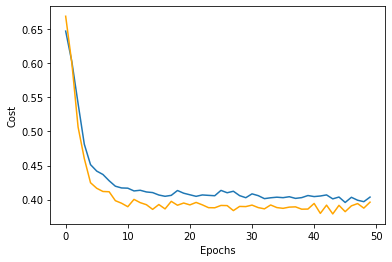

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(EPOCHS), train_losses, label='training')
plt.plot(range(EPOCHS), val_losses, label='validation', color='orange')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

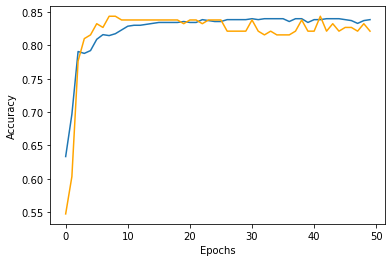

In [30]:
plt.plot(range(EPOCHS), train_accs, label='training')
plt.plot(range(EPOCHS), val_accs, label='validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [31]:
# with open("./weights/titanic_ann.pkl", "rb") as f:
#     model = pickle.load(f)
pred = model.predict(val_X)
# val_Y = enc.inverse_transform(val_Y).reshape(val_Y.shape[0])
print("Accuracy:", len(pred[val_Y.reshape(val_Y.shape[0]) == pred]) / len(pred))
from sklearn.metrics import confusion_matrix
array = confusion_matrix(val_Y.reshape(val_Y.shape[0]), pred)

Accuracy: 0.8212290502793296


In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

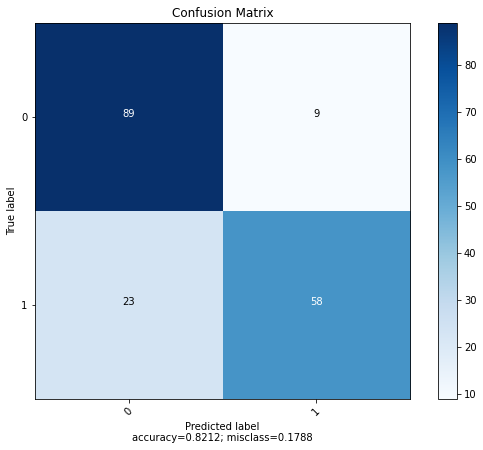

In [33]:
plot_confusion_matrix(cm           = array,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

## <font color='blue'>Kiểm tra (test)

**1. Đọc dữ liệu tập kiểm tra vào data frame `test_input_df`**

In [34]:
test_input_df = pd.read_csv('./sample_datas/titanic/test.csv', index_col=0)
test_input_df.info()
test_input_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**2. Xây dựng `test_X` từ `test_input_df`**

In [35]:
test_X = process_new_input_df(test_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)

418
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Age            418 non-null    float64
 2   SibSp          418 non-null    int64  
 3   Parch          418 non-null    int64  
 4   female         418 non-null    float64
 5    Mr            418 non-null    float64
 6    Miss          418 non-null    float64
 7    Master        418 non-null    float64
 8    Dr            418 non-null    float64
 9    the Countess  418 non-null    float64
 10   Capt          418 non-null    float64
 11   Jonkheer      418 non-null    float64
 12   Col           418 non-null    float64
 13   Don           418 non-null    float64
 14   Major         418 non-null    float64
 15   Mlle          418 non-null    float64
 16   Mme           418 non-null    float64
 17   Rev           418 non-null    float64
 18   Ms

**3. Dự đoán nhãn lớp của test_X**

In [38]:
# with open("./weights/titanic_ann.pkl", "rb") as f:
#             nn = pickle.load(f)
        
# Predict
preds = model.predict(test_X)
preds_df = pd.DataFrame(preds, index=test_input_df.index, columns=['Survived'])
preds_df.head()
# preds_df.to_csv('predicts/titanic_ann_preds.csv')

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


*submit file `titanic_ann_preds.csv` lên [Kaggle](https://www.kaggle.com/c/titanic/submissions/attach), và ghi nhận lại độ chính xác.*

Kết quả cho single model MLP from Scratch: ```Your submission scored 0.80622```